# Import Libraries

In [1]:
import os
import sys

util_path = os.path.abspath(os.path.join('..'))

if util_path not in sys.path:
    sys.path.append(util_path)

import utility_func as util
import importlib
importlib.reload(util)

<module 'utility_func' from 'D:\\GitUpload\\CMT-GSC-AI\\utility_func.py'>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
curr_dir = os.path.abspath(os.path.join(curr_dir, '..'))
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [4]:
str_sed_data = util.pd.read_csv(data_path + '/Kodangal dataset/proc_elem_Kodangal_gcM.csv')

In [5]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,hf,ta,w,u,toposheet,in_,f,te,tl,hg
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,10.930,3.312,0.560,6.20,...,5.746369,0.862203,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,10.930,3.748,0.580,6.20,...,7.857656,0.958655,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.91,...,8.728652,1.428838,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.43,...,9.365000,1.542800,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.99,...,10.693400,1.467300,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,7.0


# EDA

In [6]:
str_elem = util.elem_list(str_sed_data)

In [7]:
len(str_elem)

61

In [8]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,lu,hf,ta,w,u,in_,f,te,tl,hg
0,44.750,10.930,3.312,0.560,6.20,1.573,0.073,0.152,1.258,0.129,...,0.335326,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0
1,45.129,10.930,3.748,0.580,6.20,1.480,0.109,0.167,1.207,0.080,...,0.391008,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0
2,58.283,12.534,7.768,1.321,2.91,1.912,0.192,0.050,0.800,0.061,...,0.508111,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0
3,61.180,11.670,8.340,1.420,2.43,1.710,0.180,0.250,0.660,0.080,...,0.531900,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0
4,60.300,11.470,8.270,1.430,1.99,1.610,0.170,0.230,0.580,0.061,...,0.524000,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,7.0


### Drop elements based on certain condition

- Elements having concentration values less than 1

In [9]:
drop_elem = ['mno', 'p2o5', 'sb', 'bi', 'se', 'in_', 'te', 'tl']

In [10]:
elem_df.drop(drop_elem, axis=1, inplace=True)

# Normalize

In [11]:
train_df = elem_df.copy()
target = elem_df['cu']
train_df.drop(['cu'], axis=1, inplace=True)

In [12]:
train_df.shape

(588, 52)

In [13]:
rs = util.RobustScaler()
norm_data = rs.fit_transform(train_df)

In [14]:
n_samples = len(train_df)
n_features = len(train_df.columns)
train_df = norm_data.reshape((n_samples, n_features, 1))
train_df.shape

(588, 52, 1)

In [15]:
X_train, X_test, y_train, y_test = util.train_test_split(train_df, 
                                                         target, 
                                                         test_size=0.1, 
                                                         random_state=42,
                                                         shuffle=True)

In [16]:
X_train, X_val, y_train, y_val = util.train_test_split(X_train, 
                                                       y_train, 
                                                       test_size=0.1, 
                                                       random_state=42,
                                                       shuffle=True)

# Model Training

## CNN

In [19]:
def cnn_model(n_features, learning_rate):
    
    model = util.Sequential()

    model.add(util.Conv1D(32, kernel_size=3, padding='same', input_shape=(n_features, 1), activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.5))

    model.add(util.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.5))

    model.add(util.Conv1D(512, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.5))

    model.add(util.Dense(32, activation='relu'))
    model.add(util.Dense(64, activation='relu'))
    model.add(util.Dense(128, activation='relu'))
    model.add(util.Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(util.Dense(1))

    opt = util.Adam(learning_rate)
    model.compile(optimizer=opt, loss='mae')

    return model

In [20]:
lr = 0.001

# lr_schdlr = LearningRateScheduler(step_decay)

lr_schdlr = util.ExponentialDecay(initial_learning_rate=lr, 
                                  decay_steps=100, 
                                  decay_rate=0.96, 
                                  staircase=True)

# lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1, 
#                               patience=5, 
#                               min_lr=0.001)

# erly_stp = EarlyStopping(monitor='val_loss', 
#                          verbose=1, 
#                          patience=20, 
#                          mode='min')

In [21]:
model = cnn_model(n_features, lr_schdlr)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 52, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 52, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 26, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 3, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 512)              │              

 Total params: 587,425 (2.24 MB)

 Trainable params: 585,441 (2.23 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [22]:
cnnmodel = model.fit(X_train, y_train, 
                     epochs=100, batch_size=32, 
                     validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 51.9701 - val_loss: 67.7758
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 33.4418 - val_loss: 63.7727
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.4551 - val_loss: 59.9377
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20.6117 - val_loss: 52.8153
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.2134 - val_loss: 55.4486
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.7972 - val_loss: 51.6124
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 18.9600 - val_loss: 46.3374
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 17.5544 - val_loss: 46.0179
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 17.1461 - val_loss: 45.8712
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.8776 - val_loss: 44.0622
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.2704 - val_loss: 40.5804
Epoch 12/100
15/15 ━━━━━━━━━━━

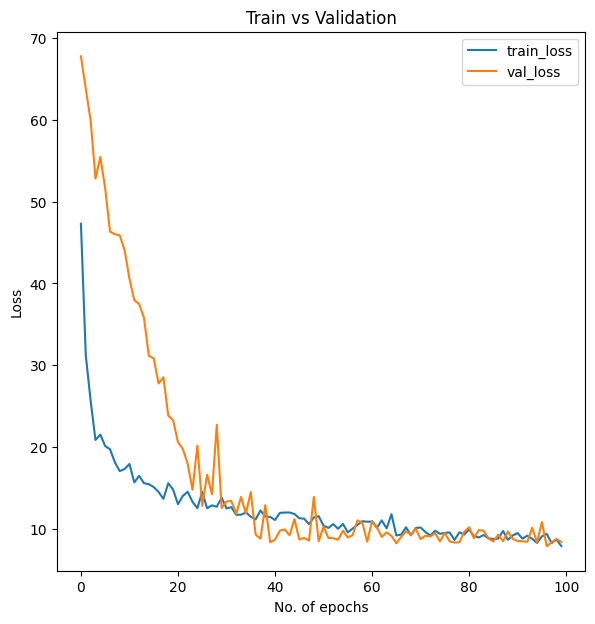

In [23]:
util.metrics_graph(cnnmodel, 100)

In [24]:
## Save the model
model.save(curr_dir + '/Models/Kodangal/CNNModel_cu.keras')
print('Saved sample model to disk')

Saved sample model to disk


In [12]:
model = load_model(curr_dir + '/Models/Kodangal/CNNModel_cu.keras')

NameError: name 'load_model' is not defined

In [22]:
image_path = curr_dir + '/Images'
plot_model(model, to_file=image_path + '/CNN_Kodangal_cu.png', show_shapes=True, show_layer_names=True, rankdir='LR')

img = plt.imread(image_path + '/CNN_Kodangal_cu.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [120]:
new_inp = np.expand_dims(X_test[0], axis=0)
new_inp.shape

(1, 52, 1)

In [25]:
def predict(model, X, y, n_bins):

    y_pred = model.predict(X).flatten()

    percentiles = np.linspace(0, 100, n_bins+1)
    bin_edges = np.percentile(y, percentiles)

    bin_labels = [f"{int(percentiles[i])}-{int(percentiles[i+1])}%" for i in range(len(percentiles) - 1)]

    bin_indices = np.digitize(y_pred, bin_edges, right=True)

    bin_indices = np.clip(bin_indices - 1, 0, len(bin_labels) - 1)

    pred_cat = [bin_labels[i] for i in bin_indices]

    return pred_cat, bin_edges, y_pred    

In [27]:
pred_catg, bins, y_pred = predict(model, X_test, y_train, 5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [39]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Absolute Error: 7.230000019073486


In [32]:
plot_vals = pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

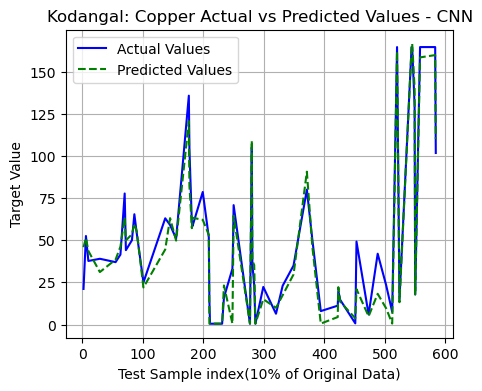

In [33]:
plt.figure(figsize=(5, 4))
plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
plt.title('Kodangal: Copper Actual vs Predicted Values - CNN')
plt.xlabel('Test Sample index(10% of Original Data)')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
bins

array([  0.5,  11.8,  30. ,  48.1,  93. , 164.5])

In [155]:
catg = list(set(pred_catg))
catg

['20-40%', '80-100%', '60-80%', '0-20%', '40-60%']

In [166]:
def extract_lower_bound(range_str):
    # Extract the first number using regular expressions
    return int(re.findall(r'\d+', range_str)[0])

catg = sorted(catg, key=extract_lower_bound)

bins_range = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

ppm_conc_cu = pd.DataFrame({
    'ppm' : bins_range,
    '% range' : catg
})
ppm_conc_cu

,ppm,% range
0,0.5-11.8,0-20%
1,11.8-30.0,20-40%
2,30.0-48.1,40-60%
3,48.1-93.0,60-80%
4,93.0-164.5,80-100%


# CNN for Features from RFECV

In [12]:
features = util.pd.read_excel(data_path+'/Kodangal dataset/Kodangal_element_names.xlsx', sheet_name='Copper')

In [13]:
fs_elem_df = elem_df[features['Elements']]
fs_elem_df.head()

,sio2,al2o3,fe2o3,tio2,na2o,k2o,ba,ga,sc,v,pb,ni,rb,y,zr,nb,zn,as_,be,f
0,44.750,10.930,3.312,0.560,0.152,1.258,727.47,13.43,7.06,63.89,6.80,40.87,53.180990,31.23,198.45,13.42,27.53,3.363592,0.743877,322.0
1,45.129,10.930,3.748,0.580,0.167,1.207,891.11,13.06,7.06,72.94,12.59,43.91,55.568333,32.49,198.45,10.40,36.11,5.687992,0.936991,336.0
2,58.283,12.534,7.768,1.321,0.050,0.800,627.92,18.57,15.29,158.12,23.21,76.62,69.889223,27.52,281.60,19.29,69.18,10.460731,1.259806,205.0
3,61.180,11.670,8.340,1.420,0.250,0.660,525.90,18.40,15.30,180.70,27.90,91.90,77.224600,36.40,332.40,13.80,57.60,14.249800,1.869500,230.0
4,60.300,11.470,8.270,1.430,0.230,0.580,509.60,18.50,16.80,171.70,25.90,90.60,84.837800,35.90,334.20,19.40,51.50,14.026200,1.978200,300.0


# Normalize

In [14]:
fs_train_df = fs_elem_df.copy()

In [15]:
fs_train_df.shape

(588, 20)

In [16]:
rs = util.RobustScaler()
fs_norm_data = rs.fit_transform(fs_train_df)

In [17]:
n_samples = len(fs_train_df)
n_features = len(fs_train_df.columns)
fs_train_df = fs_norm_data.reshape((n_samples, n_features, 1))
fs_train_df.shape

(588, 20, 1)

In [18]:
X_train, X_test, y_train, y_test = util.train_test_split(fs_train_df, 
                                                         target, 
                                                         test_size=0.1, 
                                                         random_state=42,
                                                         shuffle=True)

In [19]:
X_train, X_val, y_train, y_val = util.train_test_split(X_train, 
                                                       y_train, 
                                                       test_size=0.1, 
                                                       random_state=42,
                                                       shuffle=True)

# Model Training

## CNN

In [103]:
def cnn_model(n_features, learning_rate):
    
    model = util.Sequential()

    model.add(util.Conv1D(32, kernel_size=3, padding='same', input_shape=(n_features, 1), activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(util.BatchNormalization())
    model.add(util.MaxPool1D())
    # model.add(util.Dropout(0.5))

    # model.add(util.Conv1D(512, kernel_size=3, padding='same', activation='relu'))
    # model.add(util.BatchNormalization())
    # model.add(util.MaxPool1D())
    model.add(util.Dropout(0.3))

    model.add(util.Dense(32, activation='relu'))
    model.add(util.Dense(64, activation='relu'))
    model.add(util.Dense(128, activation='relu'))
    model.add(util.Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(util.Dense(1))

    opt = util.Adam(learning_rate)
    model.compile(optimizer=opt, loss='mae')

    return model

In [104]:
lr = 0.001

lr_schdlr = util.ExponentialDecay(initial_learning_rate=lr, 
                                  decay_steps=100, 
                                  decay_rate=0.96, 
                                  staircase=True)

In [105]:
model = cnn_model(n_features, lr_schdlr)
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_61 (Conv1D)                   │ (None, 20, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 10, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 5, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_63 (MaxPooling1D)      │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_64 (Conv1D)                   │ (None, 2, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 2, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 1, 32)               │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 1, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 183,457 (716.63 KB)

 Trainable params: 182,497 (712.88 KB)

 Non-trainable params: 960 (3.75 KB)

In [106]:
fs_cnnmodel = model.fit(X_train, y_train, 
                        epochs=100, batch_size=32, 
                        validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 51.4380 - val_loss: 67.8281
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.3824 - val_loss: 65.8437
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.5220 - val_loss: 63.2296
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.3747 - val_loss: 62.6803
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.7766 - val_loss: 57.7616
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.5778 - val_loss: 55.6779
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.8439 - val_loss: 52.0250
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.1022 - val_loss: 50.3552
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.4854 - val_loss: 48.4139
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.1370 - val_loss: 48.6693
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.6755 - val_loss: 47.1880
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

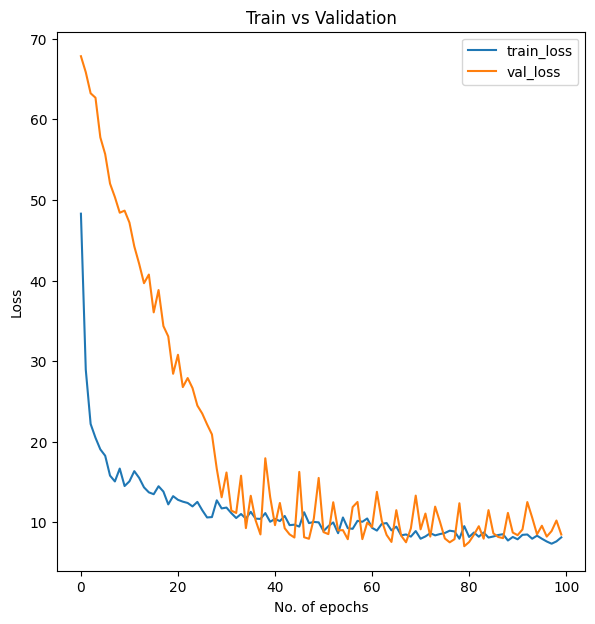

In [107]:
util.metrics_graph(fs_cnnmodel, 100)

In [108]:
## Save the model
model.save(curr_dir + '/Models/Kodangal/fs_CNNModel_cu.keras')
print('Saved sample model to disk')

Saved sample model to disk


In [20]:
model = util.tf.keras.models.load_model(curr_dir + '/Models/Kodangal/fs_CNNModel_cu.keras')

In [21]:
pred_catg, bins, y_pred = util.predict(model, X_test, y_train, 5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [22]:
mae = util.mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {util.np.round(mae, 2)}')

Mean Absolute Error: 7.93


In [23]:
plot_vals = util.pd.DataFrame({
    'Identifier': y_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

plot_vals = plot_vals.sort_values(by='Identifier')

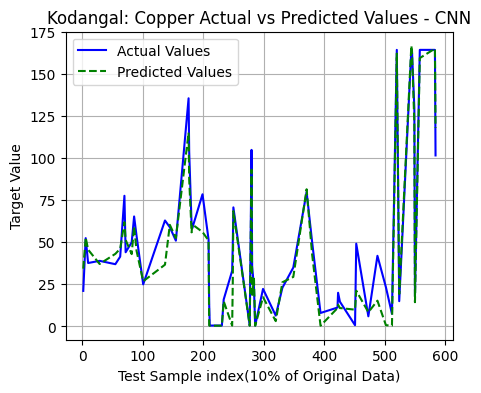

In [24]:
util.plt.figure(figsize=(5, 4))
util.plt.plot(plot_vals['Actual'], label='Actual Values', color='blue')
util.plt.plot(plot_vals['Predicted'], label='Predicted Values', color='green', linestyle='--')
util.plt.title('Kodangal: Copper Actual vs Predicted Values - CNN')
util.plt.xlabel('Test Sample index(10% of Original Data)')
util.plt.ylabel('Target Value')
util.plt.legend()
util.plt.grid(True)
util.plt.show()

In [25]:
bins

array([  0.5,  11.8,  30. ,  48.1,  93. , 164.5])

In [26]:
catg = list(set(pred_catg))
catg

['0-20%', '20-40%', '60-80%', '80-100%', '40-60%']

In [27]:
def extract_lower_bound(range_str):
    # Extract the first number using regular expressions
    return int(util.re.findall(r'\d+', range_str)[0])

catg = sorted(catg, key=extract_lower_bound)

bins_range = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

ppm_conc_cu = util.pd.DataFrame({
    'ppm' : bins_range,
    '% range' : catg
})
ppm_conc_cu

,ppm,% range
0,0.5-11.8,0-20%
1,11.8-30.0,20-40%
2,30.0-48.1,40-60%
3,48.1-93.0,60-80%
4,93.0-164.5,80-100%


In [28]:
catg, bin_edges, y = util.predict_ml(elem_df['cu'], elem_df['cu'], 5)

In [29]:
cu_dict = {
    'ppm values cnn' : list(elem_df['cu']),
    'ppm range cnn' : catg
}
cu_df = util.pd.DataFrame(cu_dict)

In [30]:
cu_df.loc[list(y_test.index), 'ppm values cnn'] = y_pred
cu_df.loc[list(y_test.index), 'ppm range cnn'] = pred_catg

In [31]:
dict = {
    'Predicted(cnn)' : cu_df['ppm values cnn'].tolist(),
    'Pred Bins(cnn)' : cu_df['ppm range cnn'].tolist()
}

df = util.pd.DataFrame(dict)

In [33]:
path = data_path + '/Kodangal dataset/actual_vs_pred_Kodangal_gcM.xlsx'
exist_df = util.pd.read_excel(path, sheet_name='Copper')

In [34]:
exist_df = util.pd.concat([exist_df, df], axis=1)
exist_df

,Actual,Predicted(rf),Pred Bins(rf),Predicted(xgb),Pred Bins(xgb),Predicted(cnn),Pred Bins(cnn)
0,34.60,34.600000,40-60%,34.600000,40-60%,34.600000,40-60%
1,33.81,33.810000,40-60%,33.810000,40-60%,33.810000,40-60%
2,21.12,49.185333,60-80%,42.260143,40-60%,34.365360,40-60%
3,55.50,55.500000,60-80%,55.500000,60-80%,55.500000,60-80%
4,53.20,53.200000,60-80%,53.200000,60-80%,53.200000,60-80%
...,...,...,...,...,...,...,...
583,164.50,162.025933,80-100%,165.362885,80-100%,165.233688,80-100%
584,101.70,125.916767,80-100%,123.992332,80-100%,118.147064,80-100%
585,126.30,126.300000,80-100%,126.300000,80-100%,126.300000,80-100%
586,164.50,164.500000,80-100%,164.500000,80-100%,164.500000,80-100%


In [41]:
sheet_to_update = 'Copper'
book = util.load_workbook(path)

if sheet_to_update in book.sheetnames:
    std = book[sheet_to_update]
    book.remove(std)

book.save(path)

with util.pd.ExcelWriter(path, engine='openpyxl', mode='a') as writer:
    exist_df.to_excel(writer, sheet_name=sheet_to_update, index=False)